[View in Colaboratory](https://colab.research.google.com/github/pamsfwang/perceptual_learning/blob/master/stochastic_stimuli_jfj.ipynb)

**Use neural network to check learning of stimuli parameters - JFJ design**   
Shao-Fang Wang 2018

- tensorflow
- three features, four levels in eahc feature, two categories
- 32 training objects in total
- one hidden layer, stochastic learning


In [178]:
!pip install sklearn

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [0]:
import tensorflow as tf
import numpy
import os
import pandas as pd

#secondary analysis
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [110]:
#Mount Google drive on Colab
#step01
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
#step02: code for mounting google drive on Linux
!mkdir -p drive
!google-drive-ocamlfuse drive

#step03: change directory to the google drive folder for the project
os.getcwd()
!ls
os.chdir('./drive/Colab_files')
os.getcwd()
!ls

gpg: keybox '/tmp/tmptwsj2er2/pubring.gpg' created
gpg: /tmp/tmptwsj2er2/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········
drive			     notebooks
jfj_stimuli_param.csv	     stimuli_param_uniqueF3.csv
jfj_stimuli_param_test.csv   stimuli_param_uniqueF3_test_new.csv
jfj_stimuli_param_train.csv  stimuli_param_uniqueF3_train_new.csv
models			     stimuli_param_uniqueF3_train_new.csv.ods
drive			     notebooks
jfj_stimuli_param.csv	     stimuli_param_uniqueF3.csv
jfj_stimuli_param_test.csv   stimuli_param_uniqueF3_test_new.csv
jfj_stimuli_param_train.csv  stimuli_param_uniqueF3_train_new.csv
models			     stimuli_param_uniqueF3_train_new.csv.ods


In [0]:
#specify variables
train_data = 'jfj_stimuli_param_train.csv' #'stimuli_param_uniqueF3_train_new.csv' 
test_data = 'jfj_stimuli_param_test.csv' #'stimuli_param_uniqueF3_test_new.csv'

num_features = 3
node_hidden01 = 6
epoch = 5000
learning_rate = 0.005
initial_weight01 = -0.01
initial_weight02 = 0.01

In [119]:
#load data
df=pd.read_csv(train_data, sep=',',header=None)
df.shape
nsamples =df.shape[0]
print "number of training samples:",nsamples

#shuffle the data
df_array = df.values
new = numpy.take(df_array,numpy.random.permutation(df_array.shape[0]),axis=0,out=df_array);

##separate data into features and labels (numpy.array)
temp = new[:,0:num_features] #df.iloc[:,0:num_features]
x_data = temp #temp.values
print "dimension of feature dataset:",x_data.shape
print(x_data[0:5,:])

temp = new[:,3]#df.iloc[:,num_features]
y_data = temp #temp.values
print "dimension of category dataset:",y_data.shape
print(y_data[0:5])


#load test data
df=pd.read_csv(test_data, sep=',',header=None)
df.shape
print "number of test samples:",df.shape[0]

##separate data into features and labels (numpy.array)
temp = df.iloc[:,0:num_features]
test_x_data = temp.values
print "dimension of feature dataset:",test_x_data.shape
print(test_x_data)

temp = df.iloc[:,num_features]
test_y_data = temp.values
print "dimension of category dataset:",test_y_data.shape
print(test_y_data)

number of training samples: 32
dimension of feature dataset: (32, 3)
[[1 0 0]
 [3 1 0]
 [4 0 1]
 [1 3 1]
 [4 4 4]]
dimension of category dataset: (32,)
[1 0 0 0 1]
number of test samples: 8
dimension of feature dataset: (8, 3)
[[1 1 2]
 [2 1 2]
 [3 3 2]
 [4 3 2]
 [1 3 2]
 [2 3 2]
 [3 1 2]
 [4 1 2]]
dimension of category dataset: (8,)
[1 1 1 1 0 0 0 0]


In [113]:
#logistic regression
logisticRegr = LogisticRegression()
logisticRegr.fit(x_data, y_data)
predictions = logisticRegr.predict(test_x_data)

acc = []
temp = predictions+test_y_data
for ii in xrange(len(temp)):
  if temp[ii] ==2 or temp[ii]==0:
    acc.append(1)
  else:
    acc.append(0)
    
accuracy_per = float(sum(acc))/float(len(acc))
print("calculate accuracy :" + repr(accuracy_per))
#print(len(acc))
#print(acc)
score = logisticRegr.score(test_x_data, test_y_data)
print(score)



calculate accuracy :0.5
0.5


In [0]:
##set up network layers
#You can think of most the tensorflow variables as actually being functions that we will call when we want to get their value. 
input_ph = tf.placeholder(tf.float32, shape=[num_features,1]) 
#This will be the place the input to the network is inserted
#shape: number of features

target_ph =  tf.placeholder(tf.float32, shape=[1,1]) 
#This will be the place the target for the network is insertedd
#shape = number of node

#First layer weights
W1 = tf.Variable(tf.random_uniform([node_hidden01,num_features],initial_weight01,initial_weight02)) 
#first layer: 3 input feautres to 10 nodes in the hidden layer

b1 = tf.Variable(tf.random_uniform([node_hidden01,1],initial_weight01,initial_weight02)) # " " biases
#one bias to the 10 nodes in the hidden layer
#[# nodes, # nodes], sampling from a random uniform distribution from -1 to 1 for initial weights

#2nd layer
W2 = tf.Variable(tf.random_uniform([1,node_hidden01],initial_weight01,initial_weight02)) 
#second layer: 10 nodes in the first hidden layer to one node in the second
b2 = tf.Variable(tf.random_uniform([1],initial_weight01,initial_weight02))


#####

##construct the network
h1 = tf.nn.tanh(tf.matmul(W1,input_ph)+b1)
#y = tanh(x1w11+x2w21)
#tf.matmul: matrix multiplication

output = tf.nn.sigmoid(tf.matmul(W2,h1)+b2) 
#This is the actual construction of the network. 
#When we want to get the output of the network, we will tell tensorflow what to put in the input placeholder, and then we'll run this output function

loss = tf.reduce_sum(tf.square(output - target_ph))
#This is the function we're trying to optimize. The reduce_sum is not really necessary since we only have a single output, just using it to flatten the output.

#optimizer = tf.train.AdamOptimizer(learning_rate) 
optimizer = tf.train.AdamOptimizer(learning_rate)
#This is a fancy version of momentum based gradient descent optimization.

train = optimizer.minimize(loss) 
#This will be how we tell the network to train on an example


In [0]:
#Define functions for calculating loss, accuracy, and hidden layer activity
def test():
    MSE = 0.0
    for i in xrange(len(x_data)):
      MSE += sess.run(loss,feed_dict={input_ph: x_data[i].reshape([num_features,1]),target_ph: y_data[i].reshape([1,1])}) #test on a test data point. feed_dict is how you pass things in to the placeholders created above
    MSE /= len(x_data)
    return MSE

def accuracy():
    temp =numpy.empty((nsamples,1))
    #acc=[]
    for i in xrange(len(x_data)):
        #temp.append(sess.run(output,feed_dict={input_ph: x_data[i].reshape([num_features,1])}))
        result = sess.run(output,feed_dict={input_ph: x_data[i].reshape([num_features,1])})
        temp[i,:] = result
        #temp= numpy.append(temp,[result],axis=0)
    return temp
    
def hidden():
    temp = numpy.empty((nsamples,node_hidden01))
    for i in xrange(len(y_data)):
        #temp.append(sess.run(h1,feed_dict={input_ph: x_data[i].reshape([num_features,1])}))
        result = sess.run(h1,feed_dict={input_ph: x_data[i].reshape([num_features,1])})
        temp[i,:]=numpy.transpose(result)
    return temp

In [120]:
# Launch the graph -- tell tensorflow to initialize everything.
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init) #first argument to sess.run is function to run, here we're running the initialize function

# Fit the function
print "Pre training MSE:", test()
ac = numpy.empty((nsamples,epoch))
hid = []#numpy.empty((node_hidden01,nsamples,epoch))
los = []
new_y = numpy.empty((nsamples,epoch))
new_x = numpy.empty((nsamples,num_features,epoch))

for step in xrange(epoch):
  #load data
  df=pd.read_csv(train_data, sep=',',header=None)
  #shuffle the data
  df_array = df.values
  new = numpy.take(df_array,numpy.random.permutation(df_array.shape[0]),axis=0,out=df_array);
  #separate data into features and labels (numpy.array)
  x_data = new[:,0:num_features] #features
  y_data = new[:,3] #labels
  
  #run the model 
  for item in xrange(nsamples):
    sess.run(train,feed_dict={input_ph: x_data[item].reshape([num_features,1]),target_ph: y_data[item].reshape([1,1])}) 
  
  
  #save out results on each iteration
  ac[:,step]=numpy.transpose(accuracy())
  #ac.append(accuracy())
  #hid[:,step]=numpy.transpose(hidden())
  hid.append(hidden())
  los.append(test())
  new_y[:,step] = y_data
  new_x[:,:,step] = x_data
  
  #print out loss
  if step % 100 == 0:
    print "On step %i, test MSE %f" %(step,test())

print "Post training MSE:", test()

Pre training MSE: 0.2500024107284844
On step 0, test MSE 0.250031
On step 100, test MSE 0.250001
On step 200, test MSE 0.250008
On step 300, test MSE 0.248399
On step 400, test MSE 0.027582
On step 500, test MSE 0.003856
On step 600, test MSE 0.000684
On step 700, test MSE 0.000131
On step 800, test MSE 0.000026
On step 900, test MSE 0.032382
On step 1000, test MSE 0.000005
On step 1100, test MSE 0.000003
On step 1200, test MSE 0.000002
On step 1300, test MSE 0.000001
On step 1400, test MSE 0.000000
On step 1500, test MSE 0.000000
On step 1600, test MSE 0.000000
On step 1700, test MSE 0.000000
On step 1800, test MSE 0.000000
On step 1900, test MSE 0.000000
On step 2000, test MSE 0.000000
On step 2100, test MSE 0.000000
On step 2200, test MSE 0.000000
On step 2300, test MSE 0.000000
On step 2400, test MSE 0.000000
On step 2500, test MSE 0.000000
On step 2600, test MSE 0.000000
On step 2700, test MSE 0.000000
On step 2800, test MSE 0.000000
On step 2900, test MSE 0.000000
On step 3000, t

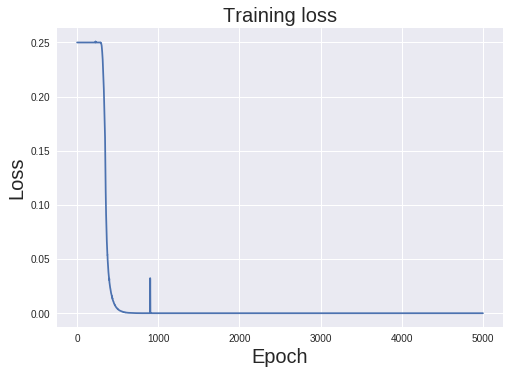

In [125]:
plt.plot(los)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch',fontsize = 20)
plt.title('Training loss', fontsize = 20)
plt.show()


In [127]:
print "Final weights:"
print(sess.run(W1),sess.run(b1),sess.run(W2),sess.run(b2))


Final weights:
(array([[ 1.8769313e+00,  1.1799088e+00, -6.9140688e-02],
       [ 3.2606950e+00, -1.3507625e+00, -2.3775776e-03],
       [ 2.4451432e+00,  1.4563602e+00, -4.0332399e-02],
       [-1.9278541e+00,  2.3642774e+00, -3.9859861e-02],
       [ 3.2728336e+00, -1.3948456e+00,  1.5154097e-03],
       [-1.9046714e+00,  2.3064952e+00, -4.9678765e-02]], dtype=float32), array([[-4.4737573],
       [-3.2082386],
       [-5.94045  ],
       [ 2.034911 ],
       [-3.085748 ],
       [ 2.0986466]], dtype=float32), array([[ -4.6568556,   8.461368 , -10.353784 ,   7.3820195,   8.587236 ,
          7.495848 ]], dtype=float32), array([-1.7511824], dtype=float32))


Dimensions of hidden layer activity mtr: 5000 32 6


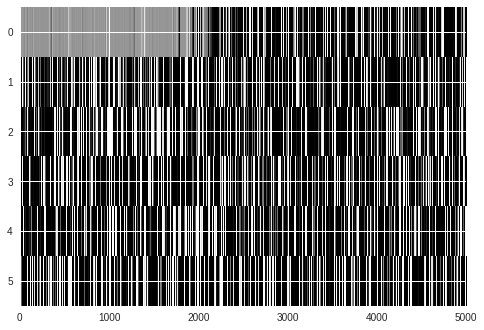

In [128]:
print("Dimensions of hidden layer activity mtr: "+repr(len(hid))+" "+ repr(len(hid[0]))+" "+repr(len(hid[0][0])))

hid_array = numpy.asarray(hid)
plt.imshow(numpy.reshape(hid_array[:,1,:],(node_hidden01,epoch)), aspect='auto')

In [0]:
#Correlations of hidden layer activity across two categories
final_co = [];#numpy.empty((0,epoch))
mean_hid_zero_activity = numpy.empty((node_hidden01,epoch))
mean_hid_one_activity = numpy.empty((node_hidden01,epoch))
for step in xrange(epoch):
  zero_ind = numpy.asarray(numpy.where(new_y[:,step]==0))
  #print(zero_ind)
  hid_zero = hid[step][zero_ind]
  hid_zeroreshape = numpy.reshape(hid_zero,(nsamples/2,node_hidden01))
  meanzero = numpy.mean(hid_zeroreshape,axis=0)
  
  one_ind = numpy.asarray(numpy.where(new_y[:,step]==1))
  #print(one_ind)
  hid_one = hid[step][one_ind]
  hid_onereshape = numpy.reshape(hid_one,(nsamples/2,node_hidden01))
  meanone = numpy.mean(hid_onereshape,axis=0)
   
  co = numpy.corrcoef(meanzero,meanone)
  final_co.append(co[0,1])
  
  #save mean activity for each epoch
  mean_hid_zero_activity[:,step]= meanzero
  mean_hid_one_activity[:,step] = meanone
  #print(co)
#print(final_co)



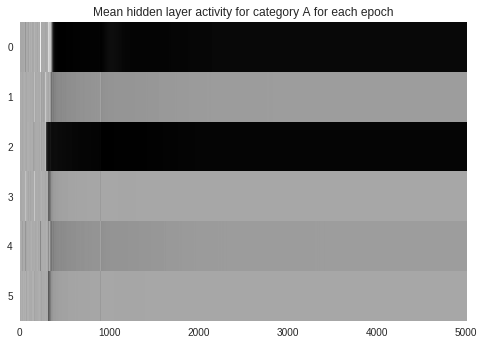

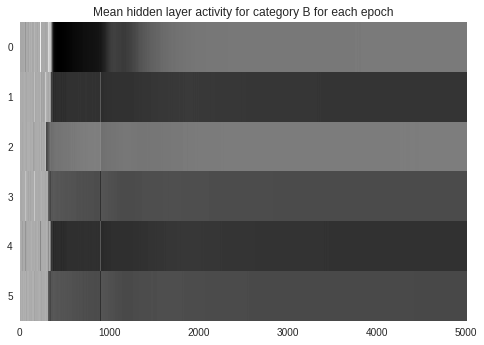

In [130]:
plt.imshow(mean_hid_zero_activity, aspect='auto')
plt.title('Mean hidden layer activity for category A for each epoch')
plt.grid(False)
plt.show()

plt.imshow(mean_hid_one_activity, aspect = 'auto')
plt.title('Mean hidden layer activity for category B for each epoch')
plt.grid(False)
plt.show()

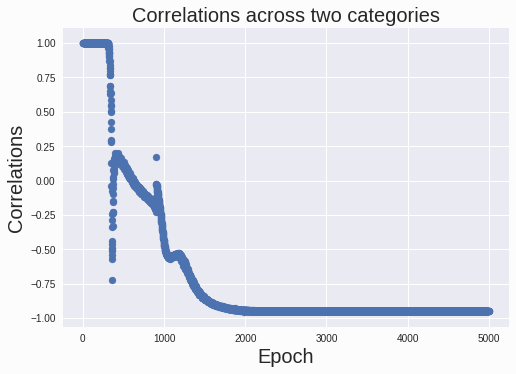

In [175]:
f = numpy.asarray(final_co)
x_epoch = numpy.asarray(range(1,epoch+1))

plt.scatter(x_epoch,f)
plt.ylabel('Correlations', fontsize = 20)
plt.xlabel('Epoch',fontsize = 20)
plt.title('Correlations across two categories', fontsize = 20)
plt.rcParams['figure.facecolor'] = '0.00'
plt.show()



In [180]:
#PAC analysis
pca = PCA(n_components=2)
step=1
#for step in xrange(epoch):
data = numpy.reshape(hid_array[step,:,:],(nsamples,node_hidden01))
pca_result = pca.fit(data)
print(pca.components_)
print(pca.explained_variance_)
print(pca_result.shape)
plt.scatter(pca_result[:, 0], pca_result[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();


[[-0.32378751  0.35078377  0.50431235  0.59607279 -0.03972231  0.40112444]
 [-0.52818398  0.48294071 -0.09501061 -0.20217387  0.54536101 -0.37479333]]
[0.00142184 0.00013177]


AttributeError: ignored

In [186]:
pca_array = numpy.asarray(pca)
type(pca)


sklearn.decomposition.pca.PCA

In [148]:
#x=pca_learn[new_y[:,0]==0,0]
new_y[:,0]==0
#x=Y_sklearn[y==name,0]

array([ True,  True, False, False, False,  True,  True, False,  True,
       False, False, False, False,  True, False,  True, False,  True,
        True,  True,  True, False,  True, False, False,  True,  True,
        True, False,  True, False, False])

In [5]:
#load test data
df=pd.read_csv(test_data, sep=',',header=None)
df.shape
print "number of test samples:",df.shape[0]

##separate data into features and labels (numpy.array)
temp = df.iloc[:,0:num_features]
test_x_data = temp.values
print "dimension of feature dataset:",test_x_data.shape
print(test_x_data)

temp = df.iloc[:,num_features]
test_y_data = temp.values
print "dimension of category dataset:",test_y_data.shape
print(test_y_data)

number of test samples: 8
dimension of feature dataset: (8, 3)
[[1 1 2]
 [2 1 2]
 [3 3 2]
 [4 3 2]
 [1 3 2]
 [2 3 2]
 [3 1 2]
 [4 1 2]]
dimension of category dataset: (8,)
[1 1 1 1 0 0 0 0]


In [33]:
# Launch the graph -- tell tensorflow to initialize everything.
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init) #first argument to sess.run is function to run, here we're running the initialize function

# Fit the function
print "Pre training MSE:", test
ac = []
hid = []
los = []
for step in xrange(600):
  for item in xrange(nsamples):
    #sess.run(train,feed_dict={input_ph: x_data[item].reshape([3,1]),target_ph: y_data[item].reshape([1,1])}) 
  sess.run(train,feed_dict={input_ph: x_data[step % nsamples].reshape([num_features,1]),target_ph: y_data[step % nsamples].reshape([1,1])}) 
  #sess.run(train): this will train the model, update the weights
  #Run training on an example
  ac.append(accuracy())
  hid.append(hidden())
  los.append(test())
  if step % 100 == 0:
    print "On step %i, test MSE %f" %(step,test())

IndentationError: ignored